In [1]:
#导入数据处理的基础包
import numpy as np
import pandas as pd
#导入用于计数的包
from collections import Counter
import os
import requests

In [2]:
#读取数据
#路径是各自数据路径的存放地址
data = pd.read_csv('JDcontents_vivo.csv',encoding="gbk")
#输出数据的一些相关信息
print(data.info())
#看数据形状 (行数, 列数)
print(data.shape)
# 列标签 <Index>
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11996 entries, 0 to 11995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   评论      11996 non-null  object
 1   评分      11996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB
None
(11996, 2)
Index(['评论', '评分'], dtype='object')


In [3]:
#观察数据格式，分别查看data的前五条数据和后五条数据
data.head()
data.tail()

,评论,评分
11991,包装很漂亮，看起来高端大气上档次，比某米看起来档次高,5
11992,外形外观：不错 屏幕音效：不错拍照效果：还行运行速度：刚刚的,5
11993,手机不错，1199买的，618活动1299，619凌晨0点降价100，。。。然后保价，赠品变...,5
11994,是1049,5
11995,正品IQoo，手机颜色好看很好看，运行速度快，价格实惠。拍照清晰解锁快。价格实惠屏幕显示清晰...,5


In [4]:
#目的是将label的数值 -1 缩放到[0,4]之间
def get_label(label):
    label = label - 1
    return label
data["label"] = data['评分'].apply(get_label)

In [5]:
#按评论进行去重，对于重复项，保留第一次出现的值
data = data.drop_duplicates('评论',keep='first')
#会将标签重新从零开始顺序排序,使用参数设置drop=True删除旧的索引序列
data = data.reset_index(drop=True)

In [6]:
# TODO1: 去掉一些无用的字符，自行定一个字符几何，并从文本中去掉
#去除字母数字表情和其它字符
import re
def clear_character(sentence):
    pattern1='[a-zA-Z0-9]'
    pattern2 = re.compile(u'[^\s1234567890:：' + '\u4e00-\u9fa5]+')
    pattern3='[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    line1=re.sub(pattern1,'',sentence)   #去除英文字母和数字
    line2=re.sub(pattern2,'',line1)   #去除表情和其他字符
    line3=re.sub(pattern3,'',line2)   #去除去掉残留的冒号及其它符号
    new_sentence=''.join(line3.split()) #去除空白
    return new_sentence

In [7]:
#在["评论"]这一列使用定义的"clear_character"函数
data["comment_processed"]=data['评论'].apply(clear_character)
data.head()

,评论,评分,label,comment_processed
0,您没有填写内容，默认好评,1,0,您没有填写内容默认好评
1,充电慢，快递员也不好说话！,1,0,充电慢快递员也不好说话
2,价位比实体店还贵一百多,1,0,价位比实体店还贵一百多
3,说是送蓝牙耳机，结果也没送，问客服说送完了。,1,0,说是送蓝牙耳机结果也没送问客服说送完了
4,刚买就便宜120，又没价格保护,1,0,刚买就便宜又没价格保护


In [9]:
# 导入中文分词包jieba, 并用jieba对原始文本做分词
import jieba
from tqdm import tqdm
def comment_cut(content):
    # TODO: 使用结巴完成对每一个comment的分词
#     seg = jieba.lcut(content)
    seg = list(jieba.cut(content.strip()))
    return seg
# 输出进度条
tqdm.pandas(desc='apply')
data['comment_processed'] = data['comment_processed'].progress_apply(comment_cut)
# 观察新的数据的格式
data.head()

apply:   0%|                                                                                                                                                                                                     | 0/7449 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\12722\AppData\Local\Temp\jieba.cache
Loading model cost 0.759 seconds.
Prefix dict has been built successfully.
apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7449/7449 [00:02<00:00, 3163.26it/s]


,评论,评分,label,comment_processed
0,您没有填写内容，默认好评,1,0,"[您, 没有, 填写内容, 默认, 好评]"
1,充电慢，快递员也不好说话！,1,0,"[充电, 慢, 快递, 员, 也, 不好, 说话]"
2,价位比实体店还贵一百多,1,0,"[价位, 比, 实体店, 还贵, 一百多]"
3,说是送蓝牙耳机，结果也没送，问客服说送完了。,1,0,"[说, 是, 送, 蓝牙, 耳机, 结果, 也, 没, 送, 问, 客服, 说, 送, 完, 了]"
4,刚买就便宜120，又没价格保护,1,0,"[刚买, 就, 便宜, 又, 没, 价格, 保护]"


In [26]:
# 设定停用词并从文本中去掉停用词
# 下载中文停用词表至本地目录下/root/Jupyter/Data_cleaning/stopWord中，下载地址:https://github.com/goto456/stopwords/
if not os.path.exists('stopWord.json'):
    stopWordC=""
    with open("cn_stopwords.txt","r",encoding='utf-8') as f:
        stopWordC = f.read()
        #print(stopWord)
    #stopWord = requests.get("https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt")
    with open("stopWord.json", "wb") as f1:
         f1.write(stopWordC)
# 读取下载的停用词表，并保存在列表中
#with open("stopWord.json","r",encoding='utf-8') as f:
#    stopWords = f.read().split("\n")  
with open("cn_stopwords.txt","r",encoding='utf-8') as f:
    stopWords = f.read().split("\n")  
    
# 去除停用词
def rm_stop_word(wordList):
    # your code, remove stop words
    # TODO
    #outstr = ''
    # 去停用词
    #for word in wordList:
       # if word not in stopWords:
           # if word != '\t':
                #outstr += word
                #outstr += " "
    #return outstr
    filtered_words = [word for word in wordList if word not in stopWords]
    return filtered_words
    #return " ".join(filtered_words)
#这行代码中.progress_apply()函数的作用等同于.apply()函数的作用，只是写成.progress_apply()函数才能被tqdm包监控从而输出进度条。
data['comment_processed'] = data['comment_processed'].progress_apply(rm_stop_word)
# 观察新的数据的格式
data.head()

apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7449/7449 [00:02<00:00, 3466.41it/s]


,评论,评分,label,comment_processed
0,您没有填写内容，默认好评,1,0,"[没有, 填写内容, 默认, 好评]"
1,充电慢，快递员也不好说话！,1,0,"[充电, 慢, 快递, 员, 不好, 说话]"
2,价位比实体店还贵一百多,1,0,"[价位, 实体店, 还贵, 一百多]"
3,说是送蓝牙耳机，结果也没送，问客服说送完了。,1,0,"[说, 送, 蓝牙, 耳机, 没, 送, 问, 客服, 说, 送, 完]"
4,刚买就便宜120，又没价格保护,1,0,"[刚买, 便宜, 没, 价格, 保护]"


In [27]:
# 去除低频词, 去掉词频小于10的单词，并把结果存放在data['comment_processed']里
from collections import Counter
list_set = []
for i in range(len(data)):
    for j in data.iloc[i]['comment_processed']: 
        list_set.extend(j)
        
words_count = Counter(list_set)
 
min_threshold=10
my_dict = {k: v for k, v in words_count.items() if v < min_threshold}
filteredA = Counter(my_dict)
 
# 去除低频词
def rm_low_frequence_word(wordList):
    # your code, remove stop words
    # TODO
    outstr = ''
    for word in wordList:
        if word not in filteredA:
            if word != '\t':
                outstr += word
                outstr += " "
    #filtered_words = [word for word in wordList if word not in filteredA]
    return outstr
                      
#这行代码中.progress_apply()函数的作用等同于.apply()函数的作用，只是写成.progress_apply()函数才能被tqdm包监控从而输出进度条。
data['comment_processed'] = data['comment_processed'].progress_apply(rm_low_frequence_word)
data.head()

apply: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7449/7449 [00:00<00:00, 158914.42it/s]


,评论,评分,label,comment_processed
0,您没有填写内容，默认好评,1,0,没有 填写内容 默认 好评
1,充电慢，快递员也不好说话！,1,0,充电 慢 快递 员 不好 说话
2,价位比实体店还贵一百多,1,0,价位 实体店 还贵 一百多
3,说是送蓝牙耳机，结果也没送，问客服说送完了。,1,0,说 送 蓝牙 耳机 没 送 问 客服 说 送 完
4,刚买就便宜120，又没价格保护,1,0,刚买 便宜 没 价格 保护


In [29]:
#index参数设置为False表示不保存行索引,header设置为False表示不保存列索引
data.to_csv("JDcontents_vivo_Cleaned_data.csv",index=False,header=True,encoding="utf-8")

In [30]:
#读取数据
#路径是各自数据路径的存放地址  
data = pd.read_csv('JDcontents_vivo_Cleaned_data.csv')
#输出数据的一些相关信息
print(data.info())
#看数据形状 (行数, 列数)
print(data.shape)
# 列标签 <Index>
print(data.columns )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7449 entries, 0 to 7448
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   评论                 7449 non-null   object
 1   评分                 7449 non-null   int64 
 2   label              7449 non-null   int64 
 3   comment_processed  7428 non-null   object
dtypes: int64(2), object(2)
memory usage: 232.9+ KB
None
(7449, 4)
Index(['评论', '评分', 'label', 'comment_processed'], dtype='object')


In [31]:
#精简列
data.drop(["评论","评分"],axis=1,inplace=True)
#删除空值
data = data.dropna(axis=0,how='any')
#重新保存
data.to_csv("JDcontents_vivo_Cleaned_data.csv",index=False,header=True,encoding="utf-8")

In [32]:
#统计评分的分布
data["label"].value_counts()

label
4    3204
0    2187
2    1443
1     582
3      12
Name: count, dtype: int64

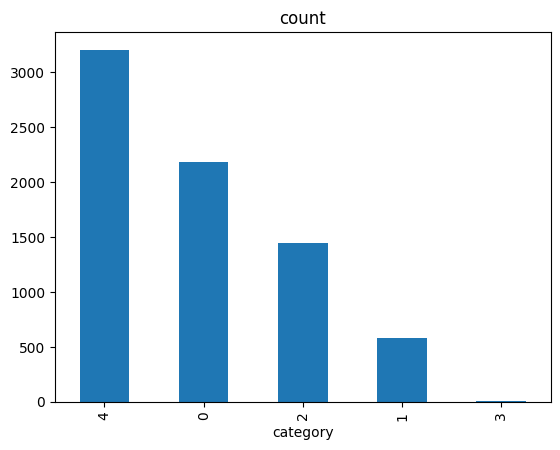

In [34]:
#生成评分-数量直方图
import matplotlib.pyplot as plt
data['label'].value_counts().plot(kind='bar')
plt.title('count')
plt.xlabel("category")
#plt.savefig('./category.png')
plt.show()

In [36]:
#统计单词的个数来得到每个句子的长度
data['text_len'] = data['comment_processed'].apply(lambda x: len(x.split(' ')))
print(data['text_len'].describe())

count    7428.000000
mean       19.494615
std        17.145183
min         2.000000
25%         8.000000
50%        14.000000
75%        26.000000
max       171.000000
Name: text_len, dtype: float64


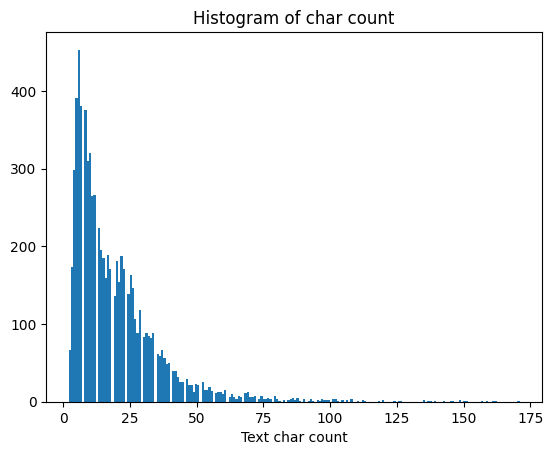

In [37]:
_ = plt.hist(data['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")
#plt.savefig('./text_chart_count.png')
plt.show()